# DOTA vs AOE image classifier

This notebook has a model that classifies a given game image between Age of Empires(AOE) or DOTA 2.

In [1]:
from vid_util import load_data
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from keras.layers import Input, Dense, Conv2D, Activation, Dropout, BatchNormalization, MaxPool2D, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


Images used for training are gameplay images directly fetched from Google images for both the games. Some images are extracted from videos.

In [2]:
image_res = (72,128,3)
X, Y = load_data(image_res)

In [3]:
# Normalizing the images
X = X/255.0
print('Training image dimensions', X.shape)
print('Training label dimensions', Y.shape)

Training image dimensions (277, 72, 128, 3)
Training label dimensions (277, 1)


In [4]:
def create_model(input_shape):
    X_input = Input(shape = input_shape)

    X = MaxPool2D(pool_size=(2,2))(X_input)
    
#     X = Conv2D(filters=20, kernel_size=(3,3), strides=1, padding='SAME', kernel_initializer='glorot_uniform')(X)
#     X = Dropout(rate=0.5)(X)
#     X = BatchNormalization()(X)
#     X = Activation(activation='relu')(X)
#     X = MaxPool2D(pool_size=(4,4))(X)

    X = Flatten()(X) 
    X = Dense(1, kernel_initializer='glorot_uniform')(X)
    X = Activation(activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

Turns out that the model doesn't need any complicated network. It just needs to correctly learn the color and texture that is unique to a game, for this a single max_pooling and flattened dense layers are sufficient.

In [5]:
model  = create_model(image_res)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 128, 3)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 64, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6913      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


Just two epochs get a good accuracy on the validation data.

In [6]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model.fit(X, Y, batch_size = 8, epochs=2, validation_split=0.1)

Train on 249 samples, validate on 28 samples
Epoch 1/2
249/249 [==============================] - 0s - loss: 0.9710 - acc: 0.5823 - val_loss: 0.4432 - val_acc: 0.7857
Epoch 2/2
249/249 [==============================] - 0s - loss: 0.2120 - acc: 0.9398 - val_loss: 0.1751 - val_acc: 0.9643


## Testing it out visually on new set of real data directly from twitch stream

Let's actually try to test our classifier on screenshots of images directly from current twitch stream.

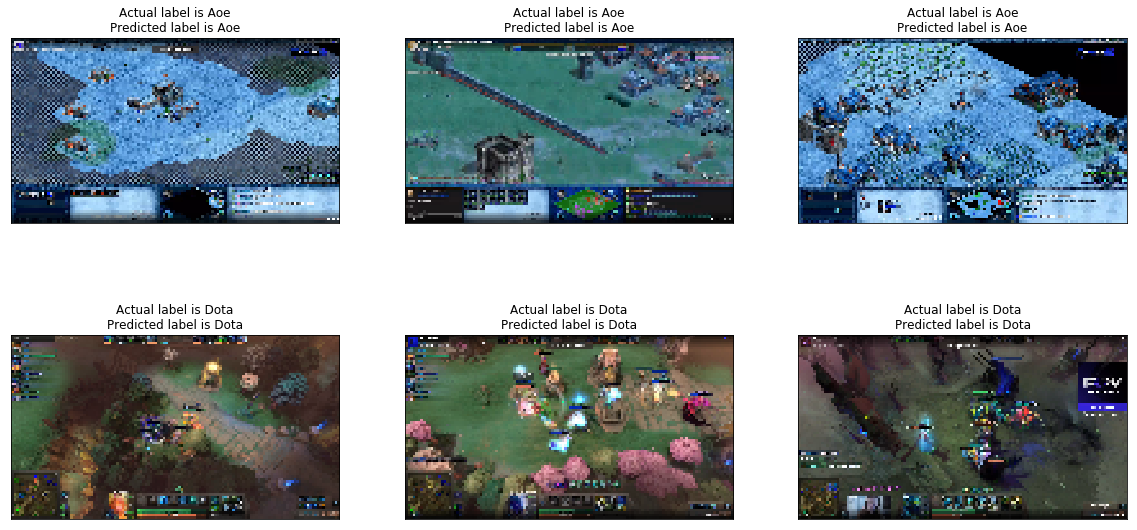

In [7]:
label_map = {1:'Aoe', 0:'Dota'}
image_res = (72,128,3)

fig, ax = plt.subplots(2,3, figsize=(20,10))
test_dir = os.path.join(os.path.curdir, 'data','images','real_test')
ix = 0
for f in os.listdir(test_dir):
    img_data = cv2.imread(os.path.join(test_dir, f))
    img_data = cv2.resize(img_data, (image_res[1], image_res[0]), interpolation=cv2.INTER_CUBIC)
    title = "Actual label is {}".format(f[:-5]) + "\n" + "Predicted label is {}".format(label_map[1 if np.asscalar(model.predict(img_data[np.newaxis,:]/255.0)) >0.5 else 0])
    ax[int(ix/3), ix%3].set_title(title)
    ax[int(ix/3), ix%3].imshow(img_data)
    ax[int(ix/3), ix%3].set_xticks([])
    ax[int(ix/3), ix%3].set_yticks([])
    ix+=1